# 02 – Modeling: External Factors and Football Win Probability

In this notebook we:

- Load the processed match-level dataset
- Define a consistent feature set (weather, travel, attendance, implied probabilities)
- Train multiple models:
  - Logistic Regression
  - Random Forest
  - Gradient Boosting
  - CatBoost (tabular gradient boosting)
- Compare models using Accuracy, AUC, and Brier score
- Select a best model and analyze:
  - Confusion matrix
  - ROC curve
  - Calibration curve
  - Prediction distribution
  - SHAP feature importance and SHAP summary plots


In [22]:
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    roc_auc_score,
    brier_score_loss,
    accuracy_score,
    confusion_matrix,
    RocCurveDisplay,
    log_loss
)
from sklearn.calibration import CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# SHAP for model explainability
import shap

# CatBoost (Sklearn-compatible wrapper)
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except ImportError:
    CATBOOST_AVAILABLE = False
    print("catboost is not installed. Run `pip install catboost` in a terminal if you want to use it.")

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


catboost is not installed. Run `pip install catboost` in a terminal if you want to use it.


In [23]:
# Notebook lives in notebooks/, data is in ../data
data_path = "../data/processed/matches_modeling_dataset.csv"
df = pd.read_csv(data_path)

print(df.shape)
df.head()


(8415, 23)


,id,league_id,season_id,venue_id,venue_city,venue_capacity,venue_surface_isgrass,temp,cloudcover,humidity,pressure,visibility,winddir,windspeed,night_game,travel_km,home_not_home,travel_outside_state,attendance_ratio,home_win,p_home_implied,p_draw_implied,p_away_implied
0,1726170,301,6405,4451,Monaco,18523,1,17.8,0,76,1014,10,12,0.00,1,482,0,1,0.495060,0,0.729825,0.175775,0.094400
1,1726172,301,6405,131,Paris,47929,1,23.3,38,45,1018,28,291,4.75,0,117,0,0,0.978489,0,0.873354,0.092171,0.034475
2,1726167,301,6405,6161,Décines-Charpieu,59186,1,26.7,85,58,1016,38,359,5.11,0,377,0,0,0.033437,0,0.707336,0.184033,0.108631
3,1726169,301,6405,2042,Longeville-lès-Metz,26661,1,20.8,17,57,1018,30,245,5.58,0,687,0,0,0.547429,1,0.323172,0.295699,0.381130
4,1726171,301,6405,126,Montpellier,22000,1,33.5,17,39,1012,51,302,5.94,0,697,0,0,0.669318,0,0.521237,0.270216,0.208548


In [24]:
feature_cols = [
    "temp",
    "humidity",
    "windspeed",
    "night_game",
    "travel_km",
    "home_not_home",
    "travel_outside_state",
    "attendance_ratio",
    "p_home_implied",
    "p_away_implied",
    "p_draw_implied",
]

target_col = "home_win"

X = df[feature_cols].copy()
y = df[target_col].astype(int).copy()

print("Feature matrix shape:", X.shape)
print("Target distribution:")
print(y.value_counts(normalize=True).rename("proportion"))


Feature matrix shape: (8415, 11)
Target distribution:
home_win
0    0.68473
1    0.31527
Name: proportion, dtype: float64


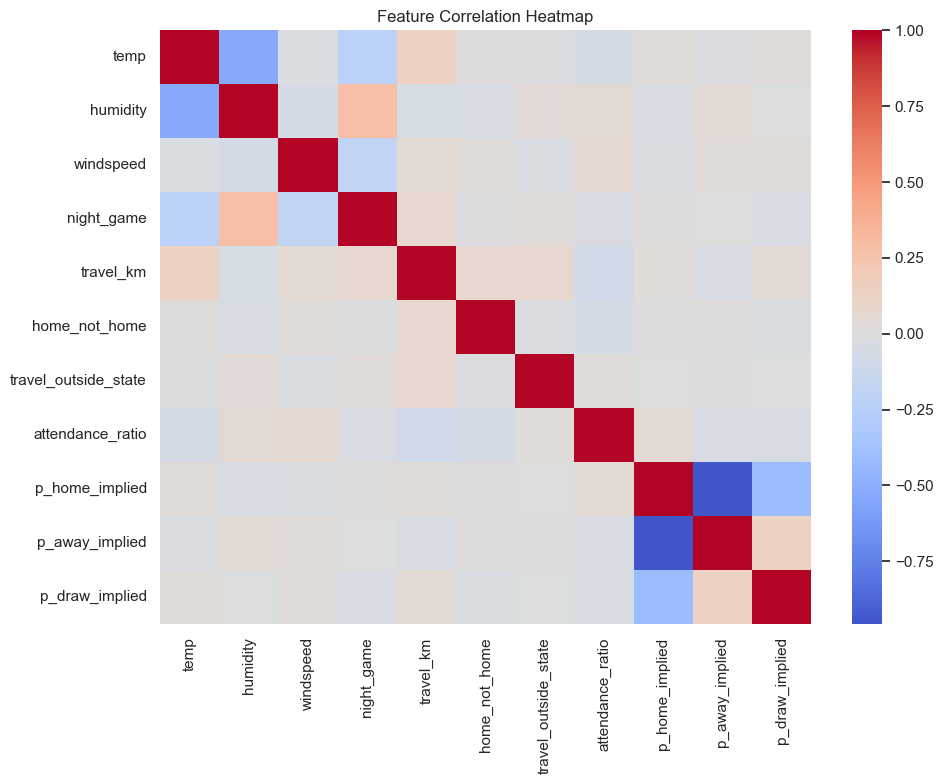

In [25]:
plt.figure(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

X_train.shape, X_test.shape


((6732, 11), (1683, 11))

In [27]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """
    Fit model, compute metrics on test data, return dict of results.
    """
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    brier = brier_score_loss(y_test, y_proba)
    ll = log_loss(y_test, y_proba)

    return {
        "model_name": name,
        "accuracy": acc,
        "auc": auc,
        "brier": brier,
        "log_loss": ll,
        "fitted_model": model,
        "y_pred": y_pred,
        "y_proba": y_proba,
    }


In [28]:
models = []

# 1. Logistic Regression (simple, baseline, interpretable)
log_reg = LogisticRegression(
    max_iter=500,
    solver="lbfgs",
)
models.append(("LogisticRegression", log_reg))

# 2. Random Forest (nonlinear baseline)
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42,
)
models.append(("RandomForest", rf_clf))

# 3. Gradient Boosting (what we used before)
gb_clf = GradientBoostingClassifier(
    random_state=42,
)
models.append(("GradientBoosting", gb_clf))

# 4. CatBoost (tabular booster) – only if available
if CATBOOST_AVAILABLE:
    cat_clf = CatBoostClassifier(
        iterations=400,
        depth=6,
        learning_rate=0.1,
        loss_function="Logloss",
        verbose=False,
        random_state=42,
    )
    models.append(("CatBoost", cat_clf))
else:
    print("Skipping CatBoost – not installed.")


Skipping CatBoost – not installed.


In [29]:
results = []
fitted_models = {}

for name, model in models:
    print(f"Training {name}...")
    res = evaluate_model(name, model, X_train, y_train, X_test, y_test)
    results.append(res)
    fitted_models[name] = res  # keep everything (model + preds)

results_df = (
    pd.DataFrame(results)
    .drop(columns=["fitted_model", "y_pred", "y_proba"])
    .sort_values("auc", ascending=False)
    .reset_index(drop=True)
)

results_df


Training LogisticRegression...


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training RandomForest...
Training GradientBoosting...


,model_name,accuracy,auc,brier,log_loss
0,LogisticRegression,0.751634,0.753606,0.175480,0.528519
1,GradientBoosting,0.745098,0.753479,0.175340,0.527790
2,RandomForest,0.730244,0.739227,0.179948,0.539046


In [30]:
# Pick the model with highest AUC
best_row = results_df.iloc[0]
best_name = best_row["model_name"]
best_info = fitted_models[best_name]

best_model = best_info["fitted_model"]
y_pred_best = best_info["y_pred"]
y_proba_best = best_info["y_proba"]

print("Best model by AUC:", best_name)
print(best_row[["accuracy", "auc", "brier", "log_loss"]])


Best model by AUC: LogisticRegression
accuracy    0.751634
auc         0.753606
brier        0.17548
log_loss    0.528519
Name: 0, dtype: object


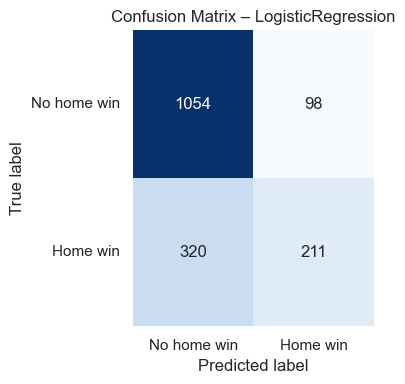

In [31]:
cm = confusion_matrix(y_test, y_pred_best)

fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    ax=ax,
)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title(f"Confusion Matrix – {best_name}")
ax.set_xticklabels(["No home win", "Home win"])
ax.set_yticklabels(["No home win", "Home win"], rotation=0)

plt.tight_layout()
plt.show()


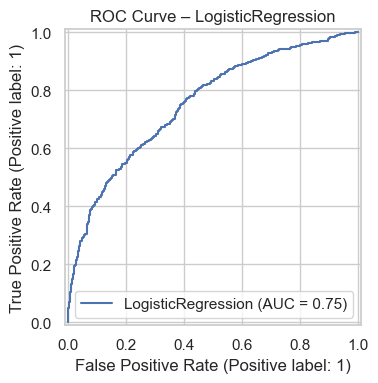

In [32]:
fig, ax = plt.subplots(figsize=(5, 4))

RocCurveDisplay.from_predictions(
    y_test,
    y_proba_best,
    name=best_name,
    ax=ax,
)

ax.set_title(f"ROC Curve – {best_name}")
plt.tight_layout()
plt.show()


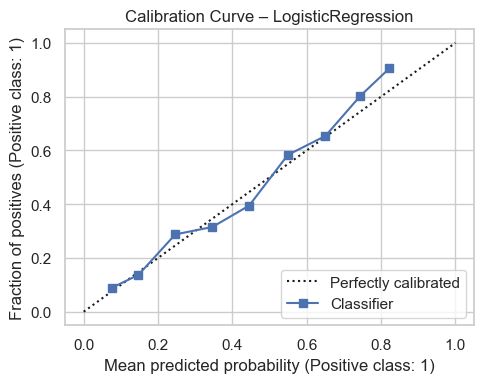

In [33]:
fig, ax = plt.subplots(figsize=(5, 4))

CalibrationDisplay.from_predictions(
    y_test,
    y_proba_best,
    n_bins=10,
    strategy="uniform",
    ax=ax,
)

ax.set_title(f"Calibration Curve – {best_name}")
plt.tight_layout()
plt.show()


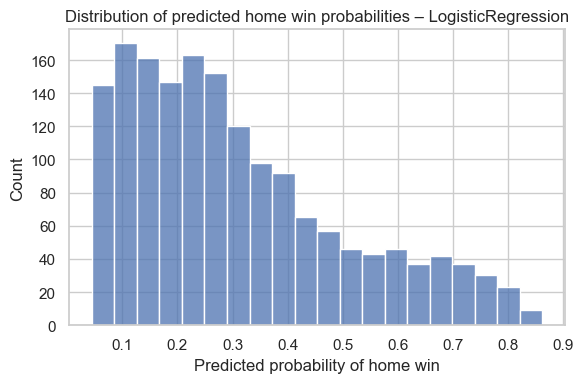

In [34]:
plt.figure(figsize=(6, 4))
sns.histplot(y_proba_best, bins=20, kde=False)
plt.xlabel("Predicted probability of home win")
plt.ylabel("Count")
plt.title(f"Distribution of predicted home win probabilities – {best_name}")
plt.tight_layout()
plt.show()


In [35]:
tree_models = {"RandomForest", "GradientBoosting", "CatBoost"}

if best_name in tree_models:
    # Use a smaller background sample for SHAP if dataset is large
    background = X_train.sample(n=min(2000, len(X_train)), random_state=42)

    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(background)

    # Global importance bar plot
    shap.summary_plot(
        shap_values,
        background,
        feature_names=background.columns,
        plot_type="bar",
        show=True,
    )
else:
    print(f"Best model is {best_name}; SHAP TreeExplainer is designed for tree-based models.")


Best model is LogisticRegression; SHAP TreeExplainer is designed for tree-based models.


In [36]:
if best_name in tree_models:
    # Beeswarm plot to show distribution of SHAP values
    shap.summary_plot(
        shap_values,
        background,
        feature_names=background.columns,
        show=True,
    )
